# Task 10
Use an INR model of your choice to represent the events in task 1. Please show a visual side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice.


**Our approach:**
we used a Fourier-based positional encoding, which is inspired by the Fourier series, though not exactly the same. <br>
An interesting alternative to normalization for enriching numerical input spaces while obtaining a normalization-like effect & gaining numerical stability is Fourier feature encoding. The algorithm is rather simple, we divide a feature by an increasing scale e.g. 2^x where x is (-1, 0, 1, 2, 3,...)  and we pass each resulting value to the sine and cosine function. Read [more](https://sair.synerise.com/fourier-feature-encoding/)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim


Each coordinate is encoded into a high-dimensional representation using sinusoidal functions at multiple frequencies.
This helps the model learn fine details and high-frequency patterns.

In [14]:
# Positional Encoding (Fourier Features)
class PositionalEncoding(nn.Module):
    def __init__(self, num_input_channels=2, num_frequencies=10):
        super().__init__()
        self.num_frequencies = num_frequencies
        self.freq_bands = 2.0 ** torch.linspace(0.0, num_frequencies - 1, num_frequencies)
        
    def forward(self, coords):
        coords = coords * 2 - 1  # normalize to [-1, 1]
        coords = coords.unsqueeze(-1)
        enc = (coords * self.freq_bands).reshape(coords.shape[0], -1)
        return torch.cat([torch.sin(enc), torch.cos(enc)], dim=-1)


A small MLP (multi-layer perceptron) takes these encoded coordinates and predicts a single pixel intensity.
It essentially "draws" the image by learning a function that maps positions to pixel values.

In [15]:

# MLP Network
class INR(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features):
        super().__init__()
        layers = [nn.Linear(in_features, hidden_features), nn.ReLU(inplace=True)]
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_features, hidden_features), nn.ReLU(inplace=True)]
        layers.append(nn.Linear(hidden_features, out_features))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)


We extract one image from a high-energy physics dataset (like jet events from LHC) — focusing on the ECAL (electromagnetic calorimeter) channel.



Generate Coordinates
For a 125×125 image, we create a 2D grid of normalized coordinates [x, y] ∈ [0, 1].
Example: top-left = [0,0], bottom-right = [1,1].

In [16]:
# Create coordinate grid
def get_mgrid(sidelen):
    coords = torch.stack(torch.meshgrid(torch.linspace(0, 1, sidelen),
                                        torch.linspace(0, 1, sidelen), indexing="ij"), dim=-1)
    return coords.reshape(-1, 2)

# Load and normalize sample ECAL channel
def load_sample_image():
    import h5py
    with h5py.File("/kaggle/input/geniedataset/quark-gluon_data-set_n139306 (1).hdf5", "r") as f:
        ecal = f['X_jets'][0, :, :, 0]  # ECAL channel of first image for demonstration
    image = torch.tensor(ecal, dtype=torch.float32)
    image /= image.max() + 1e-8
    return image


In [17]:
# Train INR
def train_inr(image, model, coords, epochs=300, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_mse = nn.MSELoss()
    image_flat = image.view(-1, 1)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(coords)
        mse_loss = criterion_mse(output, image_flat)
        ssim_score = ssim(output.view(125, 125).detach().numpy(), image.numpy(), data_range=1.0)
        loss = mse_loss + (1 - ssim_score)
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} | MSE: {mse_loss.item():.6f} | SSIM: {ssim_score:.4f}")
    return model

# Run the full pipeline
image = load_sample_image()
coords = get_mgrid(125)
pe = PositionalEncoding()
encoded_coords = pe(coords)

model = INR(in_features=encoded_coords.shape[1], hidden_features=128, hidden_layers=4, out_features=1)
trained_model = train_inr(image, model, encoded_coords)


Epoch 0 | MSE: 0.001238 | SSIM: 0.0686
Epoch 50 | MSE: 0.000081 | SSIM: 0.9684
Epoch 100 | MSE: 0.000079 | SSIM: 0.9801
Epoch 150 | MSE: 0.000075 | SSIM: 0.9793
Epoch 200 | MSE: 0.000011 | SSIM: 0.9866
Epoch 250 | MSE: 0.000010 | SSIM: 0.9883
Epoch 299 | MSE: 0.000009 | SSIM: 0.9892


Evaluation of model
* Used MSE and SSIM metrics.
* Visualized original vs. reconstructed images.



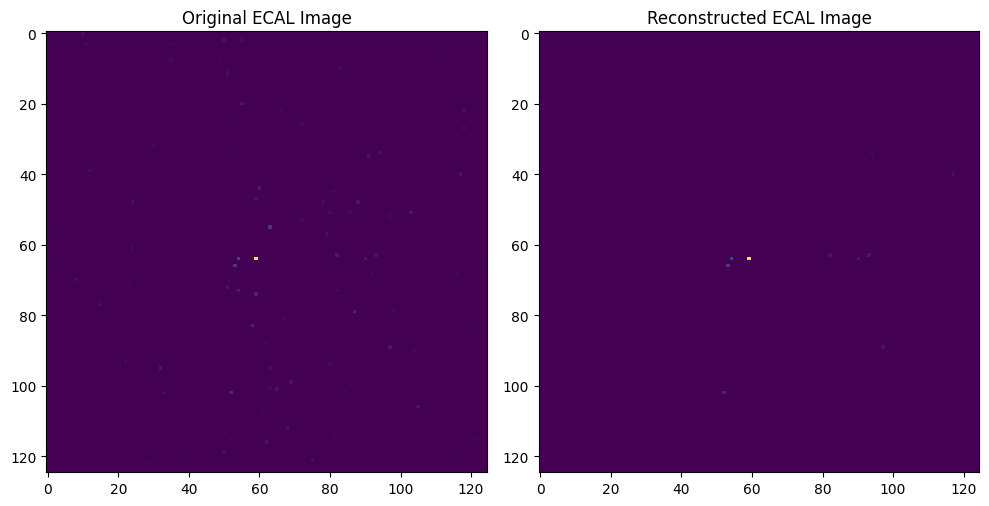

(9.122389201365877e-06, 0.9892031009710237)

In [18]:

# Reconstruct image
reconstructed = trained_model(encoded_coords).view(125, 125).detach().numpy()

# Plot original vs reconstructed
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image.numpy(), cmap="viridis")
axs[0].set_title("Original ECAL Image")
axs[1].imshow(reconstructed, cmap="viridis")
axs[1].set_title("Reconstructed ECAL Image")
plt.tight_layout()
plt.show()

# Final metrics
final_mse = F.mse_loss(torch.tensor(reconstructed), image).item()
final_ssim = ssim(reconstructed, image.numpy(), data_range=1.0)
final_mse, final_ssim
